In [1]:
#导入相应的包
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import torchvision
from torch.utils.data import DataLoader
from datetime import datetime  # 用于计算时间

import os
import sys
from collections import Counter
import re

#import tensorflow.contrib.keras as kr
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

from torchtext import data
import jieba

import cv2
import os

from torch.autograd import Variable
import tensorwatch as tw
import torchvision.models

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
torch.set_printoptions(precision=15)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
np.set_printoptions(threshold=np.inf)

from torch.optim import lr_scheduler


## 路径

In [2]:
video_path = 'C:/Users/wuxun/Desktop/Data/feat_dat/'
image_path = 'C:/Users/wuxun/Desktop/Data/image/'#存储到image文件夹中
clip_path = 'C:/Users/wuxun/Desktop/Data/clip/'
text_dir = 'C:/Users/wuxun/Desktop/Data/clear_text.txt'
vocab_dir = 'C:/Users/wuxun/Desktop/Data/vocab.txt'
train_path = 'C:/Users/wuxun/Desktop/Data/training/training.txt'
val_path = 'C:/Users/wuxun/Desktop/Data/validation/validation.txt'
csv_path = 'D:/csv/'
save_path = 'C:/Users/wuxun/Desktop/Data/save_model/'
save_path2 = 'C:/Users/wuxun/Desktop/Data/save_model2/params.pkl'

## 参数定义

In [3]:
#固定随机数种子
seed=0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# 数据处理

In [4]:
 def read_file(filename):

    """读取文件数据"""
    
    contents = []
    with open(filename) as f:
        for line in f:
            contents.append(re.split('[, \n.]',line))
    return contents

In [5]:
def build_vocab(text_dir, vocab_dir, vocab_size=3000):

    """根据训练集构建词汇表，存储"""
    data_train = read_file(text_dir)
    all_data = []
    for content in data_train:
        for k in content:
            if len(k)!=0:
                all_data.append(k)
    print(all_data)
    counter = Counter(all_data)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    open(vocab_dir, mode='w').write('\n'.join(words) + '\n')

In [6]:
def read_vocab(vocab_dir):

    """读取词汇表"""

    with open(vocab_dir) as fp:
        words = [(_.strip()) for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

In [7]:
def to_words(content, words):

    """将id表示的内容转换为文字"""

    return ''.join(words[x] for x in content)

In [8]:
def get_dict(path, csv_path):
    '''
    获得最终的数据集
    path:文本数据集
    csv_path
    '''
    words, word_to_id = read_vocab(vocab_dir)
    data_id = []
    source_csv=[]
    target_csv=[]
    fake_time_list=[]
    source_time_list=[]
    target_time_list=[]
    Max_len=-1
    count=0
    with open(path) as contents:
        for line in contents:
            count+=1
            List = line.split('#')
            video_name = List[0]
            time_length = float(List[1])
            foldtype = List[2]
            recipetype = List[3]
            source = List[4]
            target = List[5]
            fake_time = (List[7].split('_'))
            fake_time_l=int(fake_time[0])
            fake_time_r=int(fake_time[1])
            fake_time_list.append([fake_time_l, fake_time_r])
            
            #将句子转换为id表示：
            sentence = List[6].strip('\n').strip()
            sentence = re.split(r"[,| |.]",sentence)
            sentence_id = [word_to_id[x] for x in sentence if x in word_to_id]
            if len(sentence_id) > Max_len:
                Max_len = len(sentence_id)
            data_id.append(sentence_id)
            
            #寻找路径,先统一取0001
            dir_path = csv_path+'/'+foldtype+'/'+recipetype+'/'+video_name+'/0001/'
            name = os.listdir(dir_path)[0]
            dir_path = dir_path + name
            
            #读取csv文件
            my_file = Path(dir_path)
            if my_file.exists():
                frame_sum = pd.read_csv(dir_path, header=None)
            else:
                print("目录不存在！")
            
            #确定时间点
            source = source.split('_')
            target = target.split('_')
            
            source_time = (float(source[0])+float(source[1]))//2
            source_time_list.append([float(source[0]),float(source[1])])
            source_frame_num = int(source_time/time_length*500)
            source_frame = frame_sum.loc[source_frame_num]
            source_csv.append([source_frame])
            
            target_time = (float(target[0])+float(target[1]))//2
            target_time_list.append([float(target[0]),float(target[1])])
            target_frame_num = int(target_time/time_length*500)
            target_frame = frame_sum.loc[target_frame_num]
            target_csv.append([target_frame])
            
            #添加其余帧数据作为对抗样本
            fake_time = (fake_time_l + fake_time_r)//2
            fake_time_num = int(fake_time/time_length*500)
            #print(str(count)+"     "+str(fake_time_num))
            fake_frame = frame_sum.loc[fake_time_num]
            #补充数据
            source_csv.append([source_frame])
            data_id.append(sentence_id)
            target_csv.append([fake_frame])
            source_time_list.append([float(source[0]),float(source[1])])
            target_time_list.append([fake_time_l, fake_time_r])
            
    #将所有的句子pad为同一最大长度
    batch_data_id = np.array([line +[0]*(Max_len-len(line)) 
                                for line in data_id])
    batch_seq = torch.LongTensor(batch_data_id)
            
    print(len(batch_seq),len(source_csv),len(target_csv))
    
    return batch_seq, source_csv, target_csv, source_time_list, target_time_list

# 读取数据

In [9]:
#训练集
x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train = get_dict(train_path, csv_path)

3096 3096 3096


In [10]:
#验证集
x_batch_val, x_csv_val, y_csv_val, source_list_val, target_list_val = get_dict(val_path, csv_path)

1046 1046 1046


## 基础模型

### 模型定义

In [11]:
batch_size = 32
lamba = 0.2

In [12]:
# 定义LSTM的结构
class LSTM_CNN(nn.Module):
    
    def __init__(self):
        super(LSTM_CNN, self).__init__()
        
        self.embedding = nn.Embedding(5000, 64)
        self.rnn = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        #self.rnn = nn.GRU(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        self.f1 = nn.Sequential(nn.Linear(256,128),
                                nn.Dropout(0.8),
                                nn.ReLU())

        self.f2 = nn.Sequential(nn.Linear(128,64))
        
        
        self.conv1=torch.nn.Sequential(
            torch.nn.Conv1d(1,10,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
        )
        
        self.conv2=torch.nn.Sequential(
            torch.nn.Conv1d(10,20,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
        )

        #self.fc1=torch.nn.Linear(2520,128)
        self.fc1=torch.nn.Linear(512,128)
        self.fc1_drop=torch.nn.Dropout(p=0.4)
        self.fc2=torch.nn.Linear(128, 64)
        
        #特征融合
        self.final_fc = nn.Linear(in_features=128, out_features=64)
        self.score_fc = torch.nn.Conv2d(64,3,kernel_size=1,stride=1)
        
        
    def cnnout(self, x2):
        in_fc=x2.view(x2.size(0),-1)
        out_fc1=self.fc1(in_fc)
        out_drop=self.fc1_drop(out_fc1)
        out_fc2=self.fc2(out_drop)
        return out_fc2
        
    def forward(self, x1, x2): 
        if x1.shape[0]!=2:
            #lstm
            x = self.embedding(x1)
            x,_ = self.rnn(x)
            x = F.dropout(x,p=0.8)
            
            x = self.f1(x[:,-1,:])
            lstm_output = self.f2(x)
            cnn_out=self.cnnout(x2)
            #concat
            output = torch.cat((lstm_output, cnn_out), 1)
            output = self.final_fc(output)
            return output
        else:
            cnn_out=self.cnnout(x2)
            return cnn_out

### 生成批次数据

In [13]:
def batch_iter(x_batch, x_csv, y_csv, source_list, target_list, batch_size=32):

    """
    生成批次数据
    """

    data_len = x_batch.shape[0]
    num_batch = int((data_len - 1) / batch_size) + 1

    indices = np.random.permutation(np.arange(data_len))
    x_batch_shuffle = x_batch[indices]
    x_csv_shuffle =np.array(x_csv)[indices]
    y_csv_shuffle = np.array(y_csv)[indices]
    source_list = np.array(source_list)[indices]
    target_list = np.array(target_list)[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_batch_shuffle[start_id:end_id], x_csv_shuffle[start_id:end_id], y_csv_shuffle[start_id:end_id], source_list[start_id:end_id], target_list[start_id:end_id]

In [14]:
#存储loss数据
train_loss_list = []
val_loss_list = []

### 训练函数

In [15]:
def train():
    model = LSTM_CNN()
    #model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/110epoch_20200713_params.pkl'))
    Loss = torch.nn.TripletMarginLoss(margin=1.0, p=2)
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    T=Variable(torch.FloatTensor([[1.0,1.0],[1.0,1.0]]))
    best_val_loss = 1000000
    print("train begin......")

    for epoch in range(100):
        batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, batch_size)
        print("====================  epoch:"+str(epoch)+"  ========================")
        train_loss_sum = 0
        train_loss_avg = 0
        count = 0
        for x_batch, x_csv, y_csv, source_time, target_time in batch_train:
            if x_csv.shape[0]==batch_size:
                count += 1
                x1 = Variable(torch.LongTensor(x_batch))
                x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                y = Variable(torch.FloatTensor(np.array(y_csv)))
                pred_y = model(x1, x2)
                negtive = model(T, x2)
                postive = model(T, y)
                loss_reg = Loss(pred_y, postive, negtive)
                train_loss_sum += loss_reg
                optimizer.zero_grad()
                loss_reg.backward()
                #nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)#梯度裁剪
                optimizer.step()
                
        train_loss_avg = train_loss_sum /count
        print("train_loss: "+str(train_loss_sum))
        train_loss_list.append(train_loss_sum)

        #对模型进行验证：
        if (epoch+1)%5 == 0:
            print("进行验证.....")
            count = 0
            val_loss_sum = 0
            val_loss_avg = 0
            batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, batch_size)
            for x_batch, x_csv, y_csv, source_time, target_time in batch_val:
                if x_csv.shape[0]==batch_size:
                    count += 1
                    x1 = Variable(torch.LongTensor(x_batch))
                    x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                    y = Variable(torch.FloatTensor(np.array(y_csv)))
                    pred_y = model(x1, x2)
                    negtive = model(T, x2)
                    postive = model(T, y)
                    loss_reg = Loss(pred_y, postive, negtive)
                    #loss_reg = torch.abs(pred_y - postive).mean()
                    val_loss_sum += loss_reg
                    optimizer.zero_grad()
                    loss_reg.backward()
                    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)#梯度裁剪
                    optimizer.step()
                    
            val_loss_avg = val_loss_sum /count
            print("val_loss: "+str(val_loss_sum))
            val_loss_list.append(val_loss_sum)   
            torch.save(model.state_dict(), save_path+str(epoch)+'_not_better_params.pkl')
            if val_loss_sum < best_val_loss:
                torch.save(model.state_dict(), save_path+str(epoch)+'_better_params.pkl')
                best_val_loss = val_loss_sum
                print("model save!")

### 训练基础模型

In [ ]:
train()

### 绘制Loss曲线

In [16]:
def draw(train_loss_list, val_loss_list):
    x1 = range(0, len(train_loss_list))
    x2 = range(0, len(val_loss_list))
    #with plt.style.context(['science']):
    plt.subplot(2, 1, 1)
    plt.plot(x1, train_loss_list[:len(train_loss_list)], 'o-')
    plt.title('train loss vs. epoches')
    plt.ylabel('train loss')
    plt.subplot(2, 1, 2)
    plt.plot(x2,val_loss_list[:len(val_loss_list)] , '.-')
    plt.xlabel('Val loss vs. epoches')
    plt.ylabel('Val loss')
    plt.show()

In [ ]:
draw(train_loss_list, val_loss_list)

# 回归模型

### 回归模型定义

In [17]:
#超参数lambda
lamba = 0.2
batch_size2=64

In [18]:
# 定义LSTM的结构
class Change(nn.Module):
    def __init__(self):
        super(Change, self).__init__()
        #特征融合
        self.score_fc = torch.nn.Conv1d(64, 2, kernel_size=1, stride=1)
        
    def forward(self, x):
        output = x#[10, 64]
        output = output.unsqueeze(2)
        score = self.score_fc(output)
        offset_pred = score.squeeze(2)
        return offset_pred

In [19]:
model = LSTM_CNN()
Loss = nn.MSELoss()
model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/189epoch_20200713_64_dim_params.pkl'))
x1 = Variable(torch.LongTensor(x_batch_train[:10]))
x2 = Variable(torch.FloatTensor(x_csv_train[:10]))
x3 = Variable(torch.FloatTensor(target_list_train[:10]))
print("target.shape: "+str(x3.shape))
print(x3)
y = Variable(torch.FloatTensor(y_csv_train[:10]))
pred = model(x1, x2)
change_model = Change()
pred2 = change_model(pred)
print("pred2.shape: "+str(pred2.shape))
print(pred2)
loss = Loss(pred2, x3)
print(loss)

target.shape: torch.Size([10, 2])
tensor([[132., 138.],
        [ 38.,  76.],
        [173., 174.],
        [ 46.,  92.],
        [175., 193.],
        [530., 698.],
        [600., 618.],
        [193., 386.],
        [269., 319.],
        [572., 698.]])
pred2.shape: torch.Size([10, 2])
tensor([[ 10.492096900939941, -25.463617324829102],
        [ 10.588456153869629, -22.233877182006836],
        [ 12.897061347961426, -22.459053039550781],
        [-10.064876556396484,   1.429924845695496],
        [ 12.114373207092285, -18.420812606811523],
        [  7.368268013000488, -15.004589080810547],
        [-23.836320877075195,  -9.423895835876465],
        [  4.834786415100098, -53.555286407470703],
        [  6.708497047424316, -29.200901031494141],
        [ -4.756270408630371, -13.690704345703125]],
       grad_fn=<SqueezeBackward1>)
tensor(151042.531250000000000, grad_fn=<MseLossBackward>)


In [20]:
train_loss_2_list=[]
val_loss_2_list=[]
resualt_text_path='C:/Users/wuxun/Desktop/resualt.txt'

### 训练函数

In [21]:
def train_2(optimizer, change_model, scheduler):
    model = LSTM_CNN()
    Loss = nn.MSELoss()
    model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/189epoch_20200713_64_dim_params.pkl'))
    best_val_loss_2 = 1000000
    print("train begin......")
    with open(resualt_text_path,'a') as f:
        for epoch in range(200):
            batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, batch_size2)
            count = 0
            train_loss_sum = 0
            train_loss_avg = 0
            for x_batch, x_csv, y_csv, source_time, target_time in batch_train:
                if x_csv.shape[0]==batch_size2:
                    count += 1
                    x1 = Variable(torch.LongTensor(x_batch))
                    x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                    source_time = Variable(torch.FloatTensor(np.array(source_time)))
                    target_time = Variable(torch.FloatTensor(np.array(target_time)))

                    pred = model(x1, x2)
                    pred2 = change_model(pred)
                    
                    loss_reg = torch.sqrt(Loss(pred2, target_time))
                    train_loss_sum +=loss_reg
                    optimizer.zero_grad()
                    loss_reg.backward()
                    optimizer.step()
                    
            #scheduler.step()
            train_loss_avg = train_loss_sum /count
            print("[epoch: "+str(epoch)+" ]   loss= "+str(train_loss_avg)+" lr = %f" % (optimizer.param_groups[0]['lr']))
            train_loss_2_list.append(train_loss_avg)

            if (epoch+1)%5==0:
                print("进行验证.......")
                batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, batch_size2)
                count = 0
                val_loss_sum = 0
                val_loss_avg = 0 
                for x_batch, x_csv, y_csv, source_time, target_time in batch_val:
                    if x_csv.shape[0]==batch_size2:
                        count += 1
                        x1 = Variable(torch.LongTensor(x_batch))
                        x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                        source_time = Variable(torch.FloatTensor(np.array(source_time)))
                        target_time = Variable(torch.FloatTensor(np.array(target_time)))

                        pred = model(x1, x2)
                        pred2 = change_model(pred)
                        loss_reg = torch.sqrt(Loss(pred2, target_time))

                        val_loss_sum +=loss_reg
                        optimizer.zero_grad()
                        loss_reg.backward()
                        optimizer.step()
                        
                #scheduler.step()
                val_loss_avg = val_loss_sum / count
                print("[epoch: "+str(epoch)+" ]   loss= "+str(val_loss_avg)+" lr = %f" % (optimizer.param_groups[0]['lr']))
                val_loss_2_list.append(val_loss_avg) 
                torch.save(change_model.state_dict(), 'C:/Users/wuxun/Desktop/Data/save_model2/epoch'+str(epoch)+'_batchsize1_params.pkl')
                if val_loss_avg < best_val_loss_2:
                    torch.save(change_model.state_dict(), save_path2)
                    best_val_loss_2 = val_loss_avg
                    print("model save!")

### 学习率调整策略

In [22]:
def get_scheduler(optimizer, lr_policy):
    """Return a learning rate scheduler
        Parameters:
        optimizer -- 网络优化器
        opt.lr_policy -- 学习率scheduler的名称: linear | step | plateau | cosine
    """
    if lr_policy == 'linear':
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch+1))
    elif lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=18, gamma=0.1)
    elif lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0)
    else:
        print('learning rate policy [%s] is not implemented'%(lr_policy))
    return scheduler

### 定义回归模型与优化器

In [23]:
change_model = Change()
change_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model2/epoch257_batchsize1_params.pkl'))
initial_lr = 0.01
optimizer = optim.Adam(change_model.parameters(), lr = initial_lr)
scheduler = get_scheduler(optimizer, 'step')

### 训练回归模型

In [24]:
train_2(optimizer, change_model, scheduler)

train begin......
[epoch: 0 ]   loss= tensor(139.096054077148438, grad_fn=<DivBackward0>) lr = 0.010000
[epoch: 1 ]   loss= tensor(138.156982421875000, grad_fn=<DivBackward0>) lr = 0.010000
[epoch: 2 ]   loss= tensor(139.832992553710938, grad_fn=<DivBackward0>) lr = 0.010000
[epoch: 3 ]   loss= tensor(140.205551147460938, grad_fn=<DivBackward0>) lr = 0.010000
[epoch: 4 ]   loss= tensor(139.198715209960938, grad_fn=<DivBackward0>) lr = 0.010000
进行验证.......
[epoch: 4 ]   loss= tensor(136.126831054687500, grad_fn=<DivBackward0>) lr = 0.010000
model save!
[epoch: 5 ]   loss= tensor(138.494491577148438, grad_fn=<DivBackward0>) lr = 0.010000
[epoch: 6 ]   loss= tensor(139.784576416015625, grad_fn=<DivBackward0>) lr = 0.010000
[epoch: 7 ]   loss= tensor(140.725891113281250, grad_fn=<DivBackward0>) lr = 0.010000
[epoch: 8 ]   loss= tensor(140.100570678710938, grad_fn=<DivBackward0>) lr = 0.010000
[epoch: 9 ]   loss= tensor(139.572280883789062, grad_fn=<DivBackward0>) lr = 0.010000
进行验证.......


KeyboardInterrupt: 

### 绘制loss

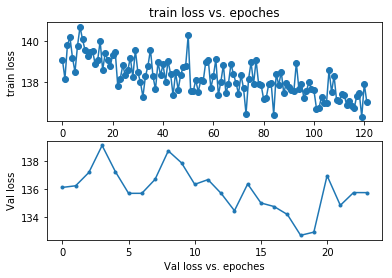

In [25]:
draw(train_loss_2_list, val_loss_2_list)

In [ ]:
model = LSTM_CNN()
Loss = nn.MSELoss()
model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/189epoch_20200713_params.pkl'))
x1 = Variable(torch.LongTensor(x_batch_train[:10]))
x2 = Variable(torch.FloatTensor(x_csv_train[:10]))
x3 = Variable(torch.FloatTensor(target_list_train[:10]))
print("target.shape: "+str(x3.shape))
print(x3)
y = Variable(torch.FloatTensor(y_csv_train[:10]))
pred = model(x1, x2)
change_model = Change()
pred2 = change_model(pred)
print("pred2.shape: "+str(pred2.shape))
print(pred2)
loss = Loss(pred2, x3)
print(loss)

### 计算R@1在tIOU为0.1/0.3/0.5/0.7的值

In [ ]:
def calculate_IoU(i0,i1):
    union = (min(i0[0], i1[0]), max(i0[1], i1[1]))
    inter = (max(i0[0], i1[0]), min(i0[1], i1[1]))
    iou = 1.0*(inter[1]-inter[0])/(union[1]-union[0])
    return iou

In [ ]:
'''
compute recall at certain IoU
'''
def compute_IoU_recall_top_n_forreg(top_n, iou_thresh, sentence_image_mat, sentence_image_reg_mat, sclips, iclips):
    correct_num = 0.0
    for k in range(sentence_image_mat.shape[0]):
        gt = sclips[k]
        gt_start = float(gt.split("_")[1])
        gt_end = float(gt.split("_")[2])
        sim_v = [v for v in sentence_image_mat[k]]
        starts = [s for s in sentence_image_reg_mat[k,:,0]]
        ends = [e for e in sentence_image_reg_mat[k,:,1]]
        picks = nms_temporal(starts,ends, sim_v, iou_thresh-0.05)
        #sim_argsort=np.argsort(sim_v)[::-1][0:top_n]
        if top_n<len(picks): picks=picks[0:top_n]
        for index in picks:
            pred_start = sentence_image_reg_mat[k, index, 0]
            pred_end = sentence_image_reg_mat[k, index, 1]
            iou = calculate_IoU((gt_start, gt_end),(pred_start, pred_end))
            if iou>=iou_thresh:
                correct_num+=1
                break
    return correct_num

### VAL_测试

In [ ]:
val = []
resualt_text_path='C:/Users/wuxun/Desktop/resulat.txt'

In [ ]:
def train_3():
    change_model = Change()
    model = LSTM_CNN()
    model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/60poch_20200713_params.pkl'))
    optimizer = optim.Adam(change_model.parameters(), lr = 0.001)
    best_val_loss_2 = 1000000
    print("train begin......")
    with open(resualt_text_path,'a') as f:
 
        for epoch in range(200):
            batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, batch_size)
            count = 0
            val_loss_sum = 0
            val_loss_avg = 0 
            val_alignmentloss_sum =0
            val_regloss_sum =0
            for x_batch, x_csv, y_csv, source_time, target_time in batch_val:
                if x_csv.shape[0]==batch_size:
                    count += 1
                    x1 = Variable(torch.LongTensor(x_batch))
                    x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                    source_time = Variable(torch.FloatTensor(np.array(source_time)))
                    target_time = Variable(torch.FloatTensor(np.array(target_time)))
                    pred = model(x1, x2)
                    pred2, loss_alignment = change_model(pred)

                    loss_reg = torch.abs(pred2 - target_time).mean()
                    for i in range(pred2.shape[0]):
                        f.write('target_time:[%d, %d]      (l_reg, r_reg):[%.3f, %.3f]\n' %(target_time[i][0],target_time[i][1],pred2[i][0], pred2[i][1]))
                        #print('target_time:[%d, %d]  (l_reg, r_reg):[%.3f, %.3f]' %(target_time[i][0],target_time[i][1],pred2[i][0], pred2[i][1]))
                    val_regloss_sum +=loss_reg
                    loss_reg = loss_reg*lamba + loss_alignment

                    val_loss_sum +=loss_reg
                    val_alignmentloss_sum += loss_alignment

                    optimizer.zero_grad()
                    loss_reg.backward()
                    nn.utils.clip_grad_norm_(change_model.parameters(), max_norm=20, norm_type=2)#梯度裁剪
                    optimizer.step()

            val_loss_avg = val_loss_sum / count
            f.write("======================================================================================\n")
            #print("============================================================================")
            #print("epoch"+str(epoch)+": sum_loss:"+str((val_loss_avg))+"  loss_alignment: "+str(val_alignmentloss_sum/count)+"  loss_reg: "+str(val_regloss_sum/count))
            f.write('[epoch:%d]     sum_loss: %.3f     loss_alignment: %.3f    loss_reg: %.3f\n' %(epoch, val_loss_avg, val_alignmentloss_sum/count, val_regloss_sum/count))
            print('[epoch:%d]   sum_loss: %.3f   loss_alignment: %.3f  loss_reg: %.3f' %(epoch, val_loss_avg, val_alignmentloss_sum/count, val_regloss_sum/count))
            val.append(val_loss_avg)        
        

In [ ]:
train_3()